# Fairness Project : Post Processes

In [3]:
#Les imports 

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from utils import *
import pickle

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import Markdown, display

from dataset_prepare import *

from sklearn.preprocessing import StandardScaler

from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm

from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification

2024-04-09 19:58:50.044789: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 19:58:50.770059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 19:58:50.770174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 19:58:50.890190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 19:58:51.123716: I tensorflow/core/platform/cpu_feature_guar

In [22]:
df_2 = load_dataset()
label = 'mortal'

In [23]:
# Récupération des ensembles de train/test
X_train, X_test, y_train, y_test = test_train_sets(df_2)

In [24]:
dataset_orig_train, dataset_orig_valid, dataset_orig_test = prepare_standard_dataset(X_train, y_train, X_test, y_test, label, vt=True)

In [25]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(117678, 24)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sexe_conducteur']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['trajet', 'catr', 'circ', 'nbv', 'prof', 'plan', 'surf', 'infra', 'situ', 'vma', 'mois', 'lum', 'dep', 'agg', 'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton', 'sexe_conducteur', 'age']


In [26]:
privileged_groups=[{'sexe_conducteur': 1}] # Hommes
unprivileged_groups = [{'sexe_conducteur' : 0}] # Femmes

In [27]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.080457


In [28]:
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()

lmod = custom_RFC(random_state=42) # Notre Classifieur
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred

## Reject option classification

In [29]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [30]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.7202
Optimal classification threshold (no fairness constraints) = 0.1288


In [31]:
metric_name = "Statistical parity difference"
metric_ub = 0.05
metric_lb = -0.05
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)

In [32]:
ROC = ROC.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [33]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.1288
Optimal ROC margin = 0.0000


In [34]:
# Transform the validation set
dataset_transf_valid_pred = ROC.predict(dataset_orig_valid_pred)

display(Markdown("#### Validation set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_valid_aft = compute_metrics(dataset_orig_valid, dataset_transf_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.7202
Statistical parity difference = -0.0018
Disparate impact = 0.9947
Average odds difference = 0.0042
Equal opportunity difference = 0.0013
Theil index = 0.0714


In [35]:
# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_orig_test_pred)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.7148
Statistical parity difference = -0.0181
Disparate impact = 0.9482
Average odds difference = 0.0015
Equal opportunity difference = 0.0110
Theil index = 0.0717


## Postprocessing avec `CalibratedEqOddsPostprocessing`

In [5]:
df = load_dataset()
label = 'mortal'

# Récupération des ensembles de train/test
X_train, X_test, y_train, y_test = test_train_sets(df)
df = df.drop(columns='Num_Acc')

In [6]:
# Récupération StandardDataset
dataset_orig_train, dataset_orig_valid, dataset_orig_test = prepare_standard_dataset(X_train, y_train, X_test, y_test, label, vt=True)

In [7]:
from utils import custom_RFC

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# Training custom Random Forest
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
lmod = custom_RFC(random_state=42)
lmod.fit(X_train, y_train)


fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = dataset_orig_valid.features
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

X_test = dataset_orig_test.features
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

In [10]:
cost_constraint = "fnr"
randseed = 42

# Learn parameters to equalize odds and apply to create a new dataset
cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)

# entrainement
cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [11]:
dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

In [12]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
bef_DI_valid = []
bef_DI_test = []
aft_DI_valid = []
aft_DI_test = []
bef_acc_valid = []
bef_acc_test = []
aft_acc_valid = []
aft_acc_test = []

for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())
    bef_acc_valid.append(classified_metric_orig_valid.accuracy())
    bef_DI_valid.append(classified_metric_orig_valid.disparate_impact())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))
    bef_acc_test.append(classified_metric_orig_test.accuracy())
    bef_DI_test.append(classified_metric_orig_test.disparate_impact())

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
        dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))
    aft_acc_valid.append(classified_metric_transf_valid.accuracy())
    aft_DI_valid.append(classified_metric_transf_valid.disparate_impact())

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))
    aft_acc_test.append(classified_metric_transf_test.accuracy())
    aft_DI_test.append(classified_metric_transf_test.disparate_impact())

#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [00:04<00:00,  6.24it/s]


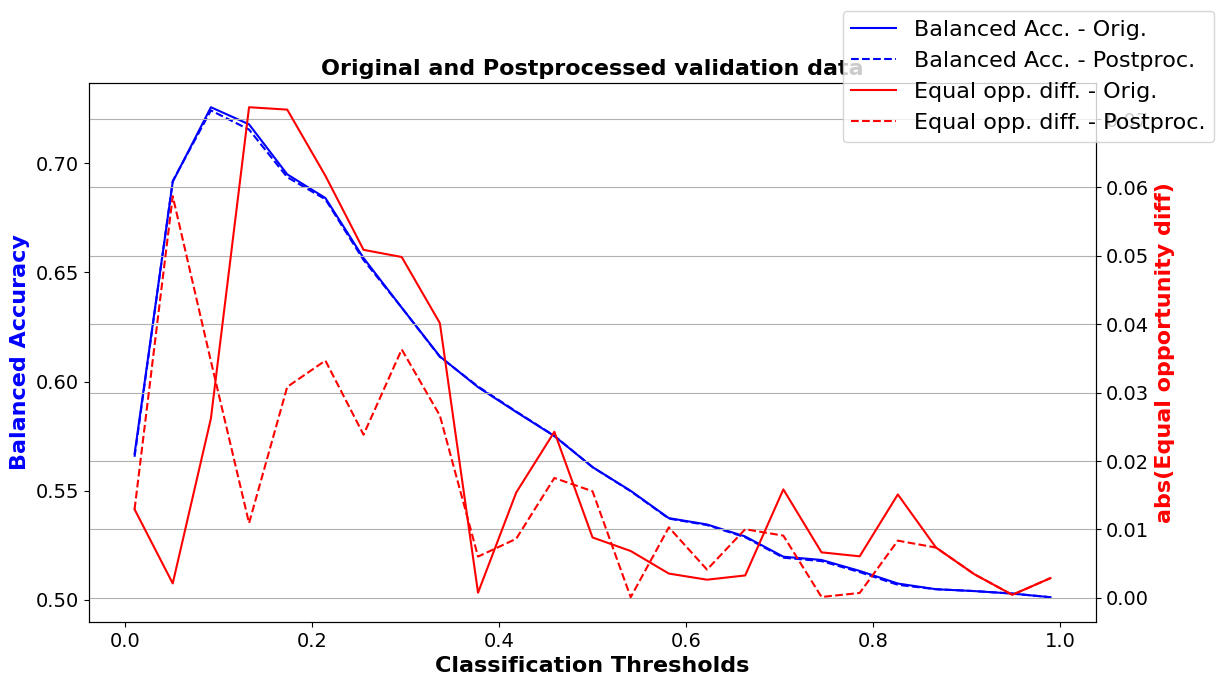

In [13]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)

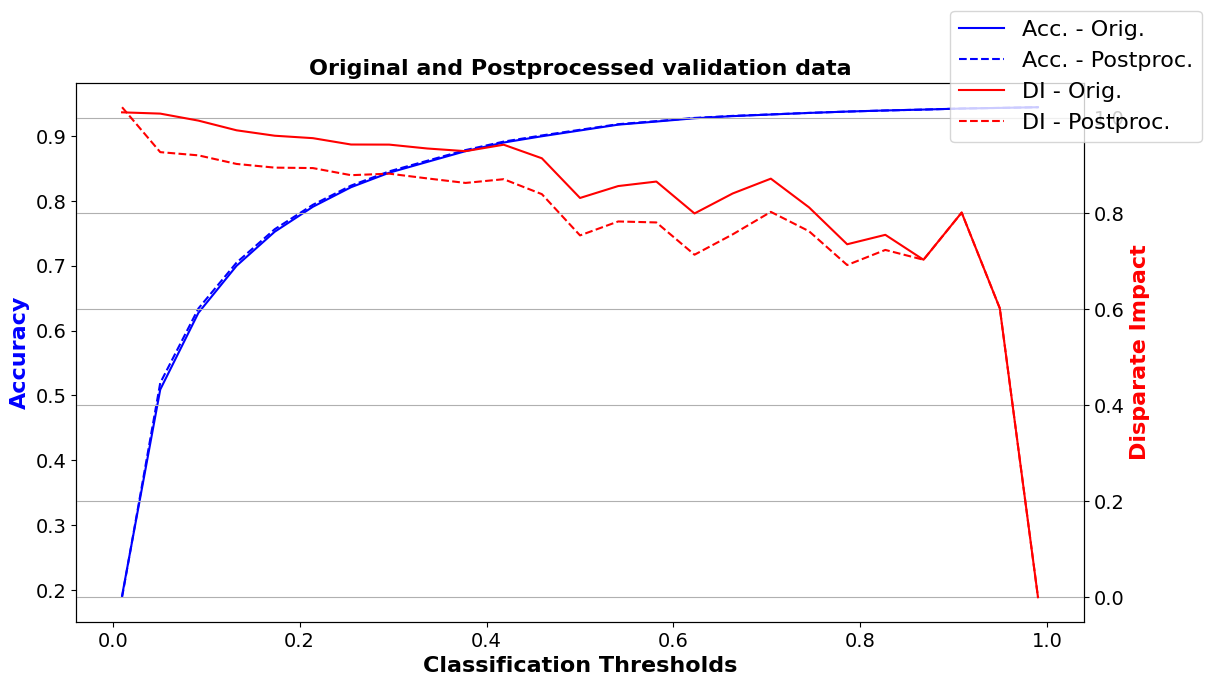

In [14]:
bef_acc_valid = np.array(bef_acc_valid)
bef_DI_valid = np.array(bef_DI_valid)

aft_acc_valid = np.array(aft_acc_valid)
aft_DI_valid = np.array(aft_DI_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_acc_valid, color='b')
ax1.plot(all_thresh, aft_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, bef_DI_valid, color='r')
ax2.plot(all_thresh, aft_DI_valid, color='r', linestyle='dashed')
ax2.set_ylabel('Disparate Impact', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Acc. - Orig.", "Acc. - Postproc.",
             "DI - Orig.","DI - Postproc.",], 
           fontsize=16)

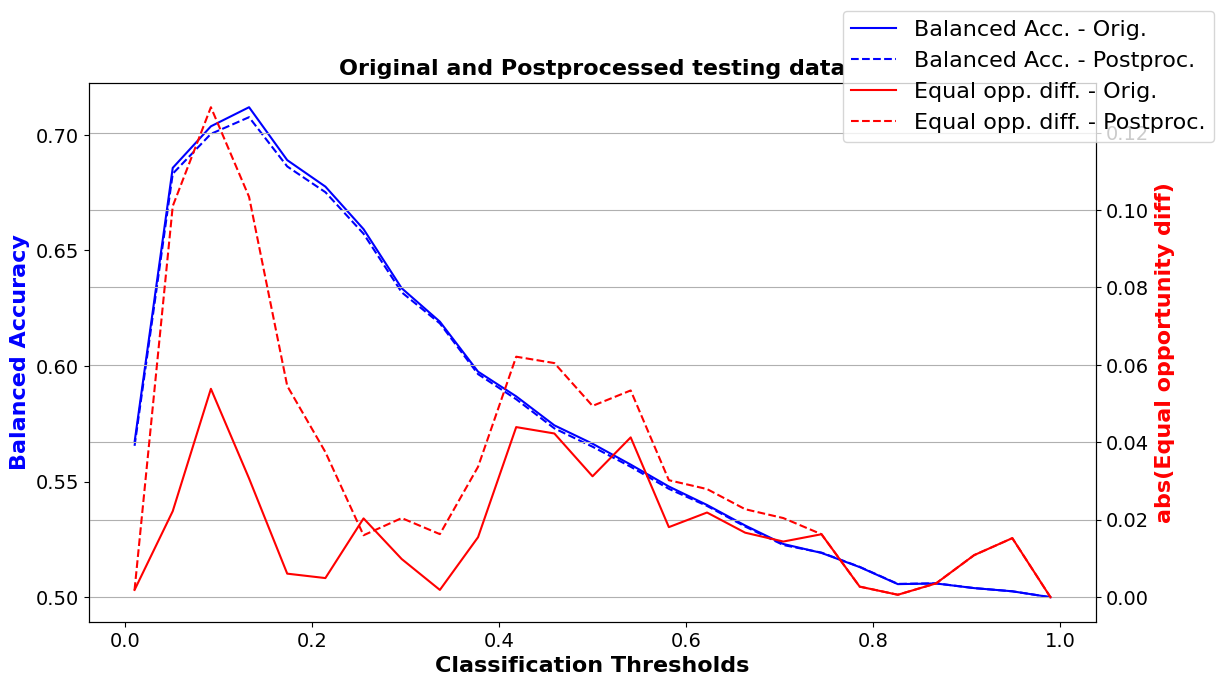

In [15]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)

In [19]:
# Affiche les valeurs réelles
all_thresh, aft_bal_acc_test, aft_avg_odds_diff_test

(array([0.01      , 0.05083333, 0.09166667, 0.1325    , 0.17333333,
        0.21416667, 0.255     , 0.29583333, 0.33666667, 0.3775    ,
        0.41833333, 0.45916667, 0.5       , 0.54083333, 0.58166667,
        0.6225    , 0.66333333, 0.70416667, 0.745     , 0.78583333,
        0.82666667, 0.8675    , 0.90833333, 0.94916667, 0.99      ]),
 array([0.56543662, 0.68316617, 0.70041849, 0.70763393, 0.68632446,
        0.67518836, 0.6572005 , 0.63185423, 0.61841004, 0.59646759,
        0.58559765, 0.57298627, 0.56504834, 0.556379  , 0.54683263,
        0.539433  , 0.53050722, 0.52251551, 0.51923206, 0.51307362,
        0.50569934, 0.50594946, 0.50387554, 0.50249187, 0.49993034]),
 array([-0.00188729, -0.1010101 , -0.12655502, -0.10340245, -0.05457204,
        -0.03748006, -0.01600213, -0.02044125, -0.01629452, -0.03367889,
        -0.06212121, -0.06047315, -0.0494152 , -0.05340245, -0.03022329,
        -0.02793727, -0.02272727, -0.02044125, -0.01626794,  0.00273791,
         0.00063796,  0.

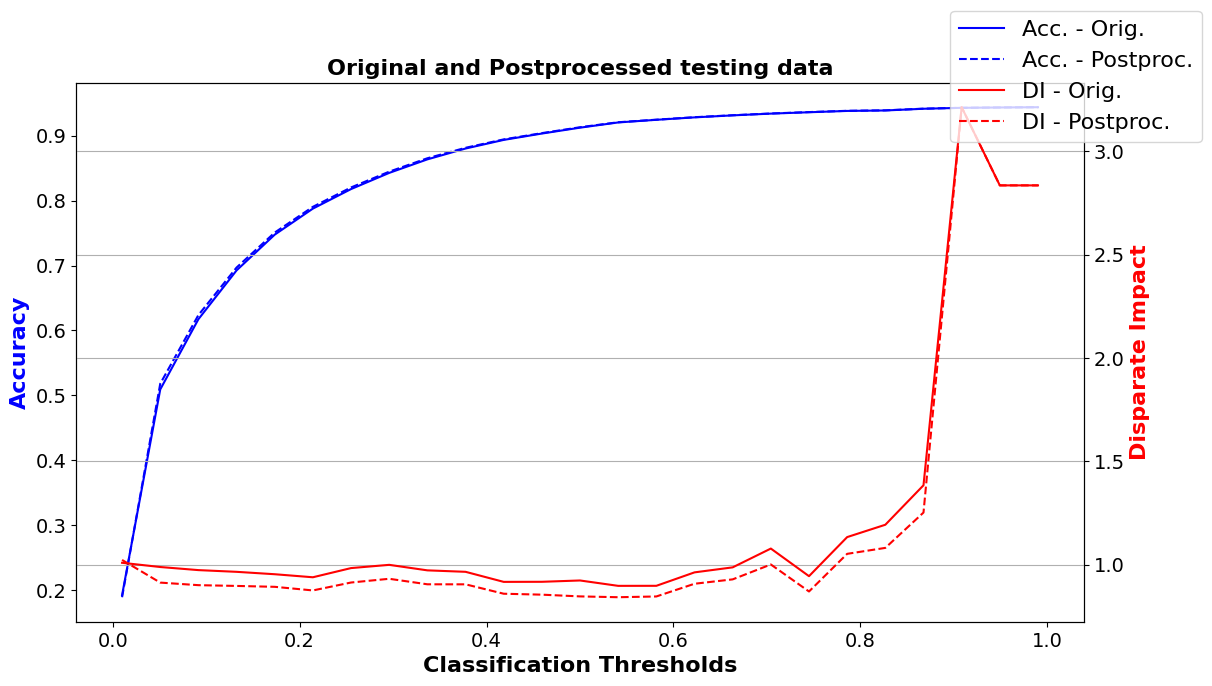

In [20]:
bef_acc_test = np.array(bef_acc_test)
bef_DI_test = np.array(bef_DI_test)

aft_acc_test = np.array(aft_acc_test)
aft_DI_test = np.array(aft_DI_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_acc_test, color='b')
ax1.plot(all_thresh, aft_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, bef_DI_test, color='r')
ax2.plot(all_thresh, aft_DI_test, color='r', linestyle='dashed')
ax2.set_ylabel('Disparate Impact', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Acc. - Orig.", "Acc. - Postproc.",
            "DI - Orig.", "DI - Postproc."], 
           fontsize=16)

In [21]:
# Affiche les valeurs réelles
all_thresh, aft_acc_test, aft_DI_test

(array([0.01      , 0.05083333, 0.09166667, 0.1325    , 0.17333333,
        0.21416667, 0.255     , 0.29583333, 0.33666667, 0.3775    ,
        0.41833333, 0.45916667, 0.5       , 0.54083333, 0.58166667,
        0.6225    , 0.66333333, 0.70416667, 0.745     , 0.78583333,
        0.82666667, 0.8675    , 0.90833333, 0.94916667, 0.99      ]),
 array([0.18881947, 0.51785597, 0.62367642, 0.6969418 , 0.75087142,
        0.79052943, 0.82038803, 0.84472213, 0.86537323, 0.88148635,
        0.89444262, 0.90411049, 0.91318645, 0.92088129, 0.92482736,
        0.92864189, 0.93166721, 0.9343637 , 0.93653403, 0.93850707,
        0.93923052, 0.94179546, 0.94311082, 0.94363696, 0.94403157]),
 array([1.02337821, 0.91384527, 0.90140887, 0.89772557, 0.893427  ,
        0.87592275, 0.91422795, 0.93225116, 0.90562106, 0.90545289,
        0.85999688, 0.85549657, 0.84707232, 0.84310997, 0.8467598 ,
        0.90823835, 0.92944411, 1.00142552, 0.87082231, 1.0529274 ,
        1.08170173, 1.25258805, 3.21277848, 